<a href="https://colab.research.google.com/github/Andi-IM/Amazon-Product-Recommendation-System/blob/main/Amazon_Electronic_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Electronic Recommender System



# About

Proyek ini akan menganalisa dataset produk amazon dan membuat model yang dapat merekomendasikan produk tertentu ke user dengan *Collaborative Filtering*.

# Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity

# this is for jupyter notebook to show the plot in the notebook itself instead of opening a new window
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andiirhamm","key":"464e90c162d7c838e2ad7b91f19165eb"}'}

In [7]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Mar  6 14:21 kaggle.json


In [8]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
%mkdir -p ~/.kaggle
%cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d karkavelrajaj/amazon-sales-dataset

  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 46.1MB/s]


In [10]:
!unzip amazon-sales-dataset.zip -d .

Archive:  amazon-sales-dataset.zip
  inflating: ./amazon.csv            


# Data Loading

In [75]:
data = pd.read_csv('amazon.csv')
pd.set_option('display.max_columns', None)
data

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,₹379,₹919,59%,4,"1,090",SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"₹2,280","₹3,045",25%,4.1,"4,118","230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the me

Output kode di atas memberikan informasi sebagai berikut:

- Terdapat 1465 baris dalam dataset.
- Terdapat 16 kolom yaitu: product_id, product_name, category, discounted_price, actual_price, discount_percentage, rating, rating_count, about_product, user_id, user_name, review_id, review_title, review_content, img_link, product_link.

# Data Understanding

## Informasi dataset

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

Dari output terlihat bahwa sebagian besar dari kolom tersebut merupakan objek, ini informasi yang kurang tepat dikarenakan beberapa kolom yang seharusnya bernilai bukan objek / string seperti pada kolom `discounted_price`, `actual_price`, `discount_percentage`, `rating`, dan `rating_count`.

**Mengubah data kolom yang dengan tipe data yang  seharusnya**

In [77]:
data['discounted_price'] = data['discounted_price'].str.replace("₹",'')
data['discounted_price'] = data['discounted_price'].str.replace(",",'')
data['discounted_price'] = data['discounted_price'].astype('float64')

data['actual_price'] = data['actual_price'].str.replace("₹",'')
data['actual_price'] = data['actual_price'].str.replace(",",'')
data['actual_price'] = data['actual_price'].astype('float64')

data['discount_percentage'] = data['discount_percentage'].str.replace('%','').astype('float64') / 100


## Null Check

In [78]:
print(data.isna().sum())
data.loc[data.rating_count.isnull(),['rating_count']]

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


,rating_count
282,NaN
324,NaN


In [79]:
# Remove rows with missing values in the rating_count column
data.dropna(subset=['rating_count'], inplace=True)
print(data.isnull().sum())

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


In [80]:
# Finding unusual string in rating column
data['rating'].value_counts()

4.1    244
4.3    230
4.2    228
4.0    129
3.9    123
4.4    123
3.8     86
4.5     75
4       52
3.7     42
3.6     35
3.5     26
4.6     17
3.3     16
3.4     10
4.7      6
3.1      4
4.8      3
3.2      2
2.8      2
3.0      2
5.0      2
2.3      1
|        1
2        1
3        1
2.6      1
2.9      1
Name: rating, dtype: int64

Terdapat nilai yang aneh di antara rating 2.0 dengan 2.3

In [81]:
# The rating column has a value with an incorrect character, so we will exclude
# the row to obtain a clean dataset.
count = data['rating'].str.contains('\|').sum()
print(f"Total rows containing '|' on 'rating': {count}")
data = data[data['rating'].apply(lambda x: '|' not in str(x))]
count = data['rating'].str.contains('\|').sum()
print(f"Total rows containing '|' on 'rating': {count}")

Total rows containing '|' on 'rating': 1
Total rows containing '|' on 'rating': 0


Maka rating dapat kita ubah sesuai dengan tipe data yang seharusnya.

In [82]:
data['rating'] = data['rating'].astype(str).str.replace(',','').astype('float64')
data['rating_count'] = data['rating_count'].astype(str).str.replace(',', '').astype('float64')

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1462 non-null   object 
 1   product_name         1462 non-null   object 
 2   category             1462 non-null   object 
 3   discounted_price     1462 non-null   float64
 4   actual_price         1462 non-null   float64
 5   discount_percentage  1462 non-null   float64
 6   rating               1462 non-null   float64
 7   rating_count         1462 non-null   float64
 8   about_product        1462 non-null   object 
 9   user_id              1462 non-null   object 
 10  user_name            1462 non-null   object 
 11  review_id            1462 non-null   object 
 12  review_title         1462 non-null   object 
 13  review_content       1462 non-null   object 
 14  img_link             1462 non-null   object 
 15  product_link         1462 non-null   o

## Duplication Check

In [84]:
data.duplicated().any()

False

In [85]:
any_duplicates = data.duplicated(subset=['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link']).any()
any_duplicates

False

tidak ada data yang duplikat

## Rating Weight

Membuat `rating_weighted` akan menguntungkan karena juga melibatkan berapa orang yang memberikan rating tersebut. Hal ini dapat membantu mengidentifikasi produk dengan kepuasan pelanggan tinggi dan banyak penilaian positif dibandingkan dengan produk dengan peringkat rata-rata tinggi tetapi sedikit penilai.

In [86]:
data['rating_weighted'] = data['rating'] * data['rating_count']
data.rating_weighted

0       101929.8
1       175976.0
2        30919.2
3       396324.6
4        71001.0
          ...   
1460      4360.0
1461     16883.8
1462      1684.8
1463     32124.0
1464     30044.1
Name: rating_weighted, Length: 1462, dtype: float64

## Pemisahan Kategori

Pemisahan kategori akan memudahkan dalam analisis dan visualisasi

In [87]:
# Sub category in the last section
data['sub_category'] = data['category'].astype(str).str.split('|').str[-1]

# Main category is the general category
data['main_category'] = data['category'].astype(str).str.split('|').str[0]
data[['main_category','sub_category']]

,main_category,sub_category
0,Computers&Accessories,USBCables
1,Computers&Accessories,USBCables
2,Computers&Accessories,USBCables
3,Computers&Accessories,USBCables
4,Computers&Accessories,USBCables
...,...,...
1460,Home&Kitchen,WaterPurifierAccessories
1461,Home&Kitchen,Rice&PastaCookers
1462,Home&Kitchen,HeatConvectors
1463,Home&Kitchen,ExhaustFans


Pemisahan kategori akan memudahkan dalam menganalisa data

## Explanatory Data Analysis (EDA)

### Distribusi produk di setiap kategori

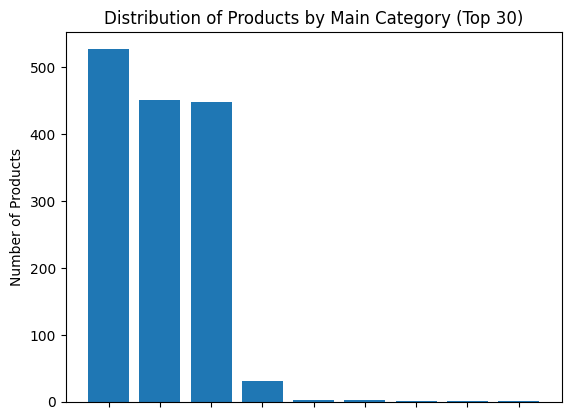

Top 30 main categories:
        Main Category  Number of Products
          Electronics                 526
Computers&Accessories                 451
         Home&Kitchen                 447
       OfficeProducts                  31
   MusicalInstruments                   2
      HomeImprovement                   2
           Toys&Games                   1
        Car&Motorbike                   1
  Health&PersonalCare                   1


In [24]:
# First step
# Analyzing distribution of products by main category
main_category_counts = data['main_category'].value_counts()[:30] # Select only the top 30 main categories.
plt.bar(range(len(main_category_counts)), main_category_counts.values)
plt.ylabel('Number of Products')
plt.title('Distribution of Products by Main Category (Top 30)')
plt.xticks(range(len(main_category_counts)), '') # hide X-axis labels
plt.show()

# Top 30 main categories
top_main_categories = pd.DataFrame({'Main Category': main_category_counts.index, 'Number of Products': main_category_counts.values})
print('Top 30 main categories:')
print(top_main_categories.to_string(index=False))

Dari output diatas, dapat diperoleh beberapa insight:

- Tiga kategori teratas adalah `Electronics`, `Computer & Accessories`, dan `Home & Kitchen`. Hal ini memperlihatkan barang-barang tersebut adalah yang terpopuler di antara pelanggan.
- Jumlah produk di `main categories` lainnya cukup sedikit, menunjukkan bahwa kategori tersebut tidak sepopuler tiga kategori teratas.
- `Office Product`, `Musical Instruments`, `Home Improvement`, `Toys & Games`, `Car & Motorbike` dan `Health & Personal Care` memiliki jumlah produk yang sedikit yang berarti permintaan pada kategori tersebut juga sedikit.
- Secara keseluruhan, data ini dapat membantu pemahaman bisnis mengenai tren pasar dan mengenali peluang menguntungkan untuk perkembangan di kategori tertentu.    

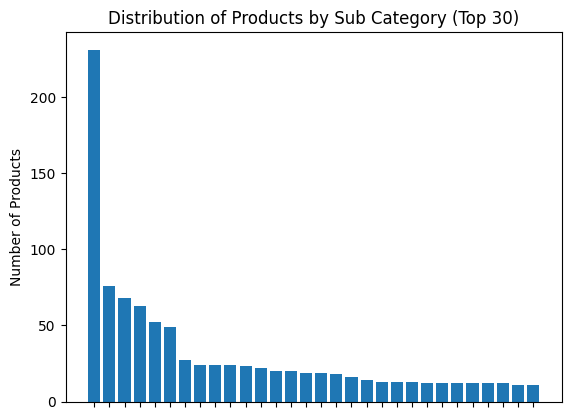

Top 30 sub categories:
            Sub Category  Number of Products
               USBCables                 231
            SmartWatches                  76
             Smartphones                  68
        SmartTelevisions                  63
                  In-Ear                  52
          RemoteControls                  49
           MixerGrinders                  27
              HDMICables                  24
                DryIrons                  24
                    Mice                  24
     InstantWaterHeaters                  23
             LintShavers                  22
              FanHeaters                  20
         ElectricHeaters                  20
         ElectricKettles                  19
            HandBlenders                  19
     WirelessUSBAdapters                  18
            WallChargers                  16
                Lapdesks                  14
          LaundryBaskets                  13
                 MicroSD        

In [25]:
# Analyzing distribution of products by last category
sub_category_counts = data['sub_category'].value_counts()[:30] # Select only the top 30 last categories.
plt.bar(range(len(sub_category_counts)), sub_category_counts.values)
plt.ylabel('Number of Products')
plt.title('Distribution of Products by Sub Category (Top 30)')
plt.xticks(range(len(sub_category_counts)), '') # hide X-axis labels
plt.show()

# Top 30 sub categories
top_sub_categories = pd.DataFrame({'Sub Category': sub_category_counts.index, 'Number of Products': sub_category_counts.values})
print('Top 30 sub categories:')
print(top_sub_categories.to_string(index=False))

Dari output di atas dapat diperoleh beberapa insight sebagai berikut:

- Enam subkategori teratas adalah `USB Cabels`, `Smartwatches`, `Smartphones`, `SmartTelevisions`, `In Ear`, dan `RemoteControls`. Subkategori tersebut merupakan yang terpopuler sehingga bisnis mungkin akan berfokus pada produk-produk tersebut.
- Subkategori terpopuler lainnya ada `MixerGrinders`, `HDMICables`, `DryIrons`, `Mice`, dan `InstantWaterHeaters`. Subkategori tersebut kurang populer jika dibandingkan dengan enam teratas, namun masih diminati dan ada kebutuhan dengan produk tersebut.
- Data di atas memperlihatkan keanekaramanan subkategori di 30 teratas meliputi peralatan dapur, barang elektronik rumah, dan aksesoris pribadi. INi memperlihatkan pentingnya untuk menyediakan produk-produk yang bervariasi untuk kebutuhan pelanggan yang berbeda-beda.
- Secara keseluruhan data tersebut membantu bisnis mengenali subkategori yang populer dan mengatur tawaran produk untuk menjangkau permintaan pelanggan. Dengan fokus pada subkategori tersebut akan membantu meningkatkan penjualan.

### Rata-rata rating untuk setiap kategori produk

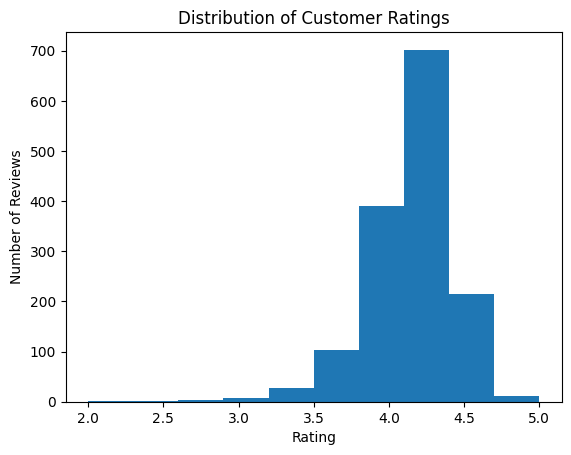

  Cluster  Number of Reviews
4     0-1                  0
3     1-2                  1
2     2-3                  8
1     3-4                525
0     4-5                928


In [26]:
plt.hist(data['rating'])
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Customer Ratings')
plt.show()

# Create table with values per cluster
bins = [0, 1, 2, 3, 4, 5] # Define bin edges
data['cluster'] = pd.cut(data['rating'], bins=bins, include_lowest=True, labels=['0-1', '1-2', '2-3', '3-4', '4-5'])
table = data['cluster'].value_counts().reset_index().sort_values('index').rename(columns={'index': 'Cluster', 'cluster': 'Number of Reviews'})
print(table)

Dari output diatas dapat dilihat bahwa:

- Mayoritas pelanggan memberi rating dari 3-4 dan 4-5, dengan total 1453 ulasan.
- Terdapat peningkatan nyata dalam jumlah ulasan pada rentang 2-3 dibandingkan dengan rentang 0-1 dan 1-2 yang lebih rendah.
- Jumlah ulasan terendah terdapat pada rentang 0-1, yang menunjukkan bahwa mungkin masih ada ruang untuk perbaikan dalam hal kepuasan pelanggan.
- Secara keseluruhan, distribusi peringkat pelanggan menunjukkan bahwa sebagian besar pelanggan puas dengan produk, namun mungkin ada peluang perbaikan untuk meningkatkan jumlah peringkat positif.

### Main Category dengan Rating Tertinggi

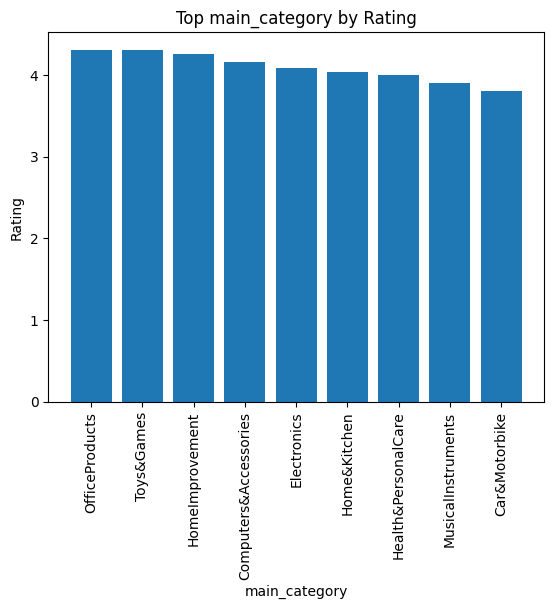

           main_category    rating
0         OfficeProducts  4.309677
1             Toys&Games  4.300000
2        HomeImprovement  4.250000
3  Computers&Accessories  4.155654
4            Electronics  4.081749
5           Home&Kitchen  4.040716
6    Health&PersonalCare  4.000000
7     MusicalInstruments  3.900000
8          Car&Motorbike  3.800000


In [27]:
# Calculate the top main categories
top = data.groupby(['main_category'])['rating'].mean().sort_values(ascending=False).head(10).reset_index()

# Create a bar plot
plt.bar(top['main_category'], top['rating'])

# Add labels and title
plt.xlabel('main_category')
plt.ylabel('Rating')
plt.title('Top main_category by Rating')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()
ranking = data.groupby('main_category')['rating'].mean().sort_values(ascending=False).reset_index()
print(ranking)

Dari output di atas dapat diperoleh informasi:

- Dapat dilihat kategori utama diurutkan berdasarkan rating rata-ratanya.
- Kategori dengan rating tertinggi adalah `OfficeProducts`, `Toys&Games`, dan `HomeImprovement` dengan rating di atas 4. Ini menyatakan bahwa pelanggan secara umum suka dengan produk yang ditawarkan pada kategori tersebut.
- Di sisi lain, kategori utama dengan rating rendah ada `Car&Motorbike`, `MusicalInstruments`,  dan `Health&PersonalCare` dengan rating di bawah 4. Ini berarti perlu adanya perbaikan untuk dapat memenuhi ekspetasi pelanggan.


### Sub Category dengan Rating Tertinggi

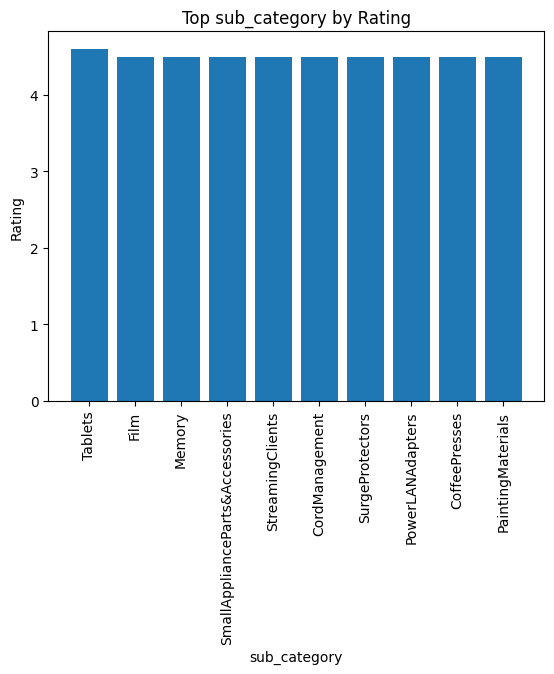

                        sub_category  rating
0                            Tablets     4.6
1                               Film     4.5
2                             Memory     4.5
3    SmallApplianceParts&Accessories     4.5
4                   StreamingClients     4.5
..                               ...     ...
202                   InkjetPrinters     3.6
203                       PCHeadsets     3.5
204                        3DGlasses     3.5
205                       DustCovers     3.4
206                 ElectricGrinders     3.3

[207 rows x 2 columns]


In [28]:
# Calculate the top sub categories
top = data.groupby(['sub_category'])['rating'].mean().sort_values(ascending=False).head(10).reset_index()

# Create a bar plot
plt.bar(top['sub_category'], top['rating'])

# Add labels and title
plt.xlabel('sub_category')
plt.ylabel('Rating')
plt.title('Top sub_category by Rating')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()
ranking = data.groupby('sub_category')['rating'].mean().sort_values(ascending=False).reset_index()
print(ranking)

Berdasarkan output diatas, dapat dilihat bahwa:

- Dari tabel dapat dilihat rating dari sub kategori dari atas hingga bawah.
- Produk "tablet", merupakan subkategori teratas dengan rating 4.6 yang berarti pelanggan puas dengan pembeliannya.
- Namun, subkategori terbawah seperti "Dustcovers" dan "ElectricGrinders", memiliki rating terendah,yang berarti pelanggan tidak begitu puas dengan produk tersebut.
- Wawasan seperti ini dapat membantu bisnis fokus pada peningkatan kualitas produk mereka dan meningkatkan pengalaman pelanggan secara keseluruhan. Penting untuk melacak umpan balik pelanggan untuk mengidentifikasi area yang perlu ditingkatkan dan terus memenuhi kebutuhan dan harapan mereka.

### Produk dengan rating terbanyak tiap kategori

In [93]:
import pandas as pd

top_reviewed_per_category = (
    data.groupby(["category"])
    .apply(lambda x: x.nlargest(10, "rating_weighted"))
    .reset_index(drop=True)
)

top_reviewed_per_category[['main_category','sub_category', 'rating', 'rating_count', 'rating_weighted']].head(10).sort_values(by=['rating_weighted'], ascending=False).reset_index(drop=True)

,main_category,sub_category,rating,rating_count,rating_weighted
0,Computers&Accessories,Webcams,4.3,20398.0,87711.4
1,Computers&Accessories,PCMicrophones,3.9,14969.0,58379.1
2,Computers&Accessories,Webcams,4.1,10976.0,45001.6
3,Computers&Accessories,PCSpeakers,4.0,7352.0,29408.0
4,Computers&Accessories,PCHeadsets,3.5,7222.0,25277.0
5,Computers&Accessories,PCSpeakers,4.1,5195.0,21299.5
6,Computers&Accessories,USBtoUSBAdapters,4.3,4426.0,19031.8
7,Computers&Accessories,PCMicrophones,3.3,2804.0,9253.2
8,Computers&Accessories,USBtoUSBAdapters,4.0,1540.0,6160.0
9,Car&Motorbike,AirPurifiers&Ionizers,3.8,1118.0,4248.4


Berdasarkan output dapat dilihat:

- Suatu produk dapat populer dengan kategorinya berdasarkan `jumlah rating` yang banyak, membuat pengguna tertarik dan ingin melihat.
- Daftar produk yang  memiliki `rating di atas 3.5` mengidikasikan pengalaman pengguna yang positif.
- Produk dengan `jumlah review` tertinggi di kategorinya berpotensi menjadi top seller meskipun tanpa melalui data penjualan secara langsung.

### Persentase Diskon dengan Main Category

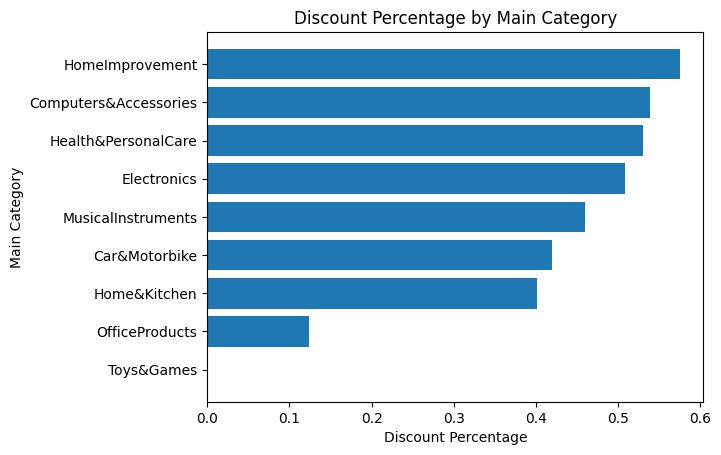

           Main Category  Mean Discount Percentage
0             Toys&Games                  0.000000
1         OfficeProducts                  0.123548
2           Home&Kitchen                  0.401745
3          Car&Motorbike                  0.420000
4     MusicalInstruments                  0.460000
5            Electronics                  0.508289
6    Health&PersonalCare                  0.530000
7  Computers&Accessories                  0.539202
8        HomeImprovement                  0.575000


In [30]:
# sort the means in descending order
mean_discount_by_category = data.groupby('main_category')['discount_percentage'].mean()
mean_discount_by_category = mean_discount_by_category.sort_values(ascending=True)

# create the horizontal bar chart
plt.barh(mean_discount_by_category.index, mean_discount_by_category.values)
plt.title('Discount Percentage by Main Category')
plt.xlabel('Discount Percentage')
plt.ylabel('Main Category')
plt.show()

table = pd.DataFrame({'Main Category': mean_discount_by_category.index, 'Mean Discount Percentage': mean_discount_by_category.values})

print(table)

Dari output diskon berdasarkan `Main Category` dapat dilihat bahwa:

- Kategori `Toys&games` memiliki permintaan yang cukup tinggi dimana penjual tidak perlu secara signifikan memberikan diskon untuk penjualan produk di kategori ini.
- `Home&Kitchen` dan `Car&Motorbike` mempunyai rata-rata persentase diskon yang serupa, dengan nilai 40% - 42%. Ini menunjukkan bahwa level kompetisi yang sama dengan sensitivitas harga di kedua kategori tersebut.
- Kategori dengan rata-rata diskon tertinggi adalah `HomeImprovement`, `Computer&Accessories`, dan `Elektronik` dengan nilai 57%, 54%, dan 51%. Ini mengindikasikan bahwa di kategori tersebut memiliki harga sangat sensitif, dan penjual harus lebih aktraktif dalam memberikan diskon untuk dapat berkompetisi lebih efektif.
- Juga menarik untuk dilihat bahwa, `OfficeProducts` dan `Health&PersonalCare` punya rata-rata diskon 12% dan 53%, yang berarti di antara kedua kategori tersebut merupakan rata-rata diskon terendah dan tertinggi. Hal ini menunjukkan bahwa kategori-kategori ini mungkin memiliki tingkat sensitivitas harga tertentu, namun tidak pada tingkat yang sama dengan `HomeImprovement`, `Computers&Accessories`, dan `Electronics`.

### Persentase diskon dengan Sub Category

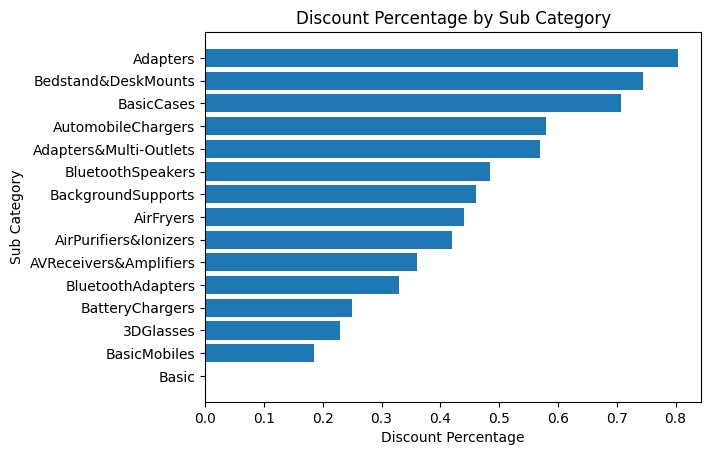

              Sub Category  Mean Discount Percentage
0                    Basic                  0.000000
1             BasicMobiles                  0.185556
2                3DGlasses                  0.230000
3          BatteryChargers                  0.250000
4        BluetoothAdapters                  0.330000
5   AVReceivers&Amplifiers                  0.360000
6    AirPurifiers&Ionizers                  0.420000
7                AirFryers                  0.440000
8       BackgroundSupports                  0.460000
9        BluetoothSpeakers                  0.485000
10  Adapters&Multi-Outlets                  0.570000
11      AutomobileChargers                  0.580000
12              BasicCases                  0.707500
13     Bedstand&DeskMounts                  0.745000
14                Adapters                  0.803333


In [31]:
# sort the means in descending order
mean_discount_by_sub_category = data.groupby('sub_category')['discount_percentage'].mean().head(15)
mean_discount_by_sub_category = mean_discount_by_sub_category.sort_values(ascending=True)

# create the horizontal bar chart
plt.barh(mean_discount_by_sub_category.index, mean_discount_by_sub_category.values)
plt.title('Discount Percentage by Sub Category')
plt.xlabel('Discount Percentage')
plt.ylabel('Sub Category')
plt.show()

table = pd.DataFrame({'Sub Category': mean_discount_by_sub_category.index, 'Mean Discount Percentage': mean_discount_by_sub_category.values})

print(table)

Dari output dapat dilihat bahwa:

- Tabel diatas memperlihatkan rata-rata diskon tiap subkategori diurutkan secara mundur.
- Subkategori yang memiliki rata-rata diskon rendah adalah `Basic`, dengan nilai 0.0. Hal ini menyatakan bahwa produk ini adalah produk dengan harga murah dan sederhana, pemberian diskon tidak memberikan efek apa-apa pada produk ini.
- `BatteryChargers`, `3DGlasses`, dan `BasicMobiles` adalah contoh subkategori dengan persentase diskon rata-rata sedang, dengan nilai antara 0.18 dan 0.25. Hal ini menunjukkan bahwa produk-produk ini mungkin sensitif terhadap harga, namun tidak pada tingkat yang sama dengan produk-produk dalam subkategori persentase diskon rata-rata yang lebih tinggi.
- `BluetoothSpeakers`, `Bedstand&DeskMounts` dan `BasicCases` adalah contoh subkategori dengan persentase diskon rata-rata tinggi, dengan nilai antara 0.485 dan 0.745. Hal ini menunjukkan bahwa produk-produk ini mungkin lebih sensitif terhadap harga, dan pengecer mungkin perlu menawarkan diskon menarik untuk bersaing secara efektif dalam subkategori ini.
- Subkategori dengan persentase mean diskon tertinggi adalah Subkategori `Adapter` dengan nilai sebesar 0,803333. Hal ini menunjukkan bahwa persaingan untuk produk-produk tersebut tinggi, dan pengecer harus menawarkan diskon yang signifikan untuk menarik pembeli.

### Statistik Deskriptif

In [92]:
unique_products_count = data['product_id'].nunique()
average_price = data['actual_price'].mean()
best_selling_product = data.loc[data['rating_count'].idxmax()]
least_selling_product = data.loc[data['rating_count'].idxmin()]
top_rated_product = data.loc[data['rating'].idxmax()]
lowest_rated_product = data.loc[data['rating'].idxmin()]
most_expensive_product = data.loc[data['actual_price'].idxmax()]
cheapest_product = data.loc[data['actual_price'].idxmin()]
highest_discount_product = data.loc[data['discount_percentage'].idxmax()]
avg_rating_count = data.groupby('product_id')['rating_count'].mean().mean()

df_anl = pd.DataFrame({
    'Pertanyaan': [
        'Jumlah Produk yang unik',
        'Harga rata-rata',
        'Produk terlaris',
        'Produk dengan penjualan paling sedikit',
        'Produk dengan rating tertinggi',
        'Produk dengan rating terendah',
        'Produk termahal',
        'Produk termurah',
        'Produk dengan diskon tertinggi',
        'Jumlah rating rata-rata untuk setiap produk'
    ],
    'Jawaban': [
        unique_products_count,
        average_price,
        best_selling_product['product_name'],
        least_selling_product['product_name'],
        top_rated_product['product_name'],
        lowest_rated_product['product_name'],
        most_expensive_product['product_name'],
        cheapest_product['product_name'],
        highest_discount_product['product_name'],
        avg_rating_count
    ],
    'Harga sebenarnya': [
        None,
        None,
        best_selling_product['actual_price'],
        least_selling_product['actual_price'],
        top_rated_product['actual_price'],
        lowest_rated_product['actual_price'],
        most_expensive_product['actual_price'],
        cheapest_product['actual_price'],
        highest_discount_product['actual_price'],
        None
    ],
    'Rating': [
        None,
        None,
        best_selling_product['rating'],
        least_selling_product['rating'],
        top_rated_product['rating'],
        lowest_rated_product['rating'],
        most_expensive_product['rating'],
        cheapest_product['rating'],
        highest_discount_product['rating'],
        None
    ],
    'Diskon': [
        None,
        None,
        best_selling_product['discount_percentage'],
        least_selling_product['discount_percentage'],
        top_rated_product['discount_percentage'] ,
        lowest_rated_product['discount_percentage'],
        most_expensive_product['discount_percentage'],
        cheapest_product['discount_percentage'],
        highest_discount_product['discount_percentage'],
        None
    ]
})

df_anl

,Pertanyaan,Jawaban,Harga sebenarnya,Rating,Diskon
0,Jumlah Produk yang unik,1348,NaN,NaN,NaN
1,Harga rata-rata,5453.087743,NaN,NaN,NaN
2,Produk terlaris,AmazonBasics Flexible Premium HDMI Cable (Blac...,700.0,4.4,0.69
3,Produk dengan penjualan paling sedikit,Khaitan ORFin Fan heater for Home and kitchen-...,2495.0,2.0,0.48
4,Produk dengan rating tertinggi,Syncwire LTG to USB Cable for Fast Charging Co...,1999.0,5.0,0.80
5,Produk dengan rating terendah,Khaitan ORFin Fan heater for Home and kitchen-...,2495.0,2.0,0.48
6,Produk termahal,Sony Bravia 164 cm (65 inches) 4K Ultra HD Sma...,139900.0,4.7,0.44
7,Produk termurah,E-COSMOS 5V 1.2W Portable Flexible USB LED Lig...,39.0,3.8,0.00
8,Produk dengan diskon tertinggi,"rts [2 Pack] Mini USB C Type C Adapter Plug, T...",4999.0,4.3,0.94
9,Jumlah rating rata-rata untuk setiap produk,17656.855341,NaN,NaN,NaN


Insight:

1. **Rating yang tinggi berkorelasi dengan tingginya penjualan**: Produk dengan rating tertinggi juga menjadi yang best seller.
2. **Rating yang rendah juga berhubungan dengan rendahnya penjualan**: Produk dengan rating terendah juga paling sedikit terjual, dan mereka mendapatkan rating sedikit.
3. **Best seller dan Produk rating teratas sangat menjanjikan**:
4. **Produk dengan harga yang kemahalan diberi rating buruk**: Produk yang memiliki rating kecil dapat menjadi mahal dari harga rata-ratanya.



### Keyword yang populer

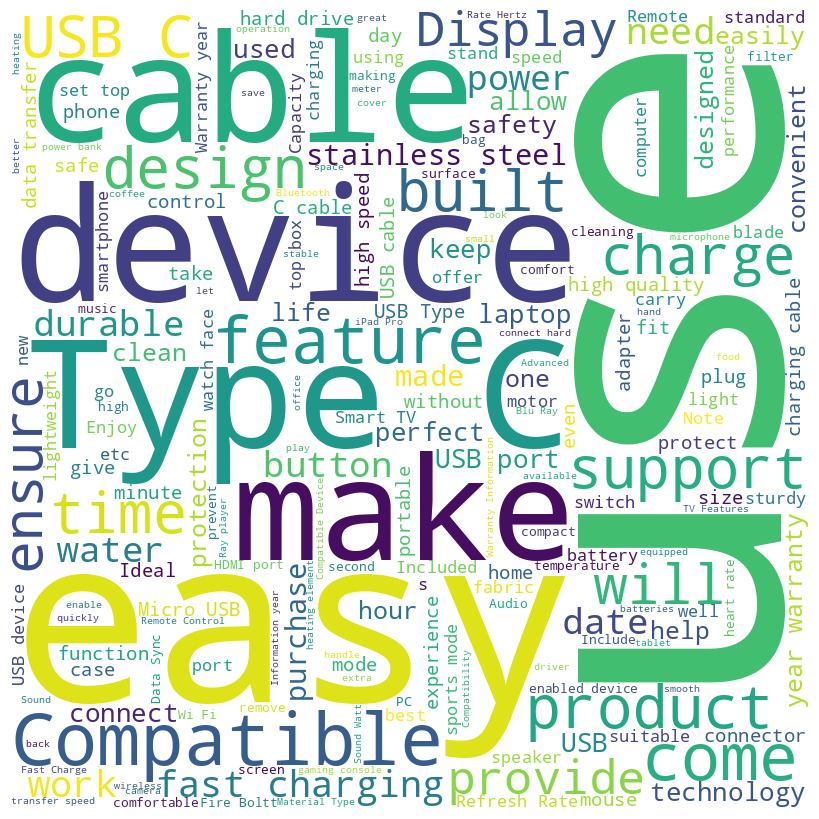

In [33]:
product_text = ' '.join(data['about_product'].dropna().values)
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(product_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Kode tersebut menghasilkan awan kata berdasarkan teks deskripsi dalam kumpulan data, agar dapat menganalisis secara visual kata-kata paling umum yang digunakan dalam fitur produk. Semakin besar kata di cloud, semakin sering kata tersebut muncul di kotak deskripsi.

## Sentiment Analysis

Analisis Sentimen atau *opinion mining* adalah bidang *Natural Language Processing* (NLP) yang berfokus pada mengidentifikasi dan mengkategorikan pendapat atau sentimen dalam teks. Tujuannya adalah untuk menentukan sikap masyarakat terhadap suatu topik, layanan, produk atau konteks keseluruhan. Sikap atau sentimen ini dikelompokkan dalam kategori seperti positif, negatif, atau netral.

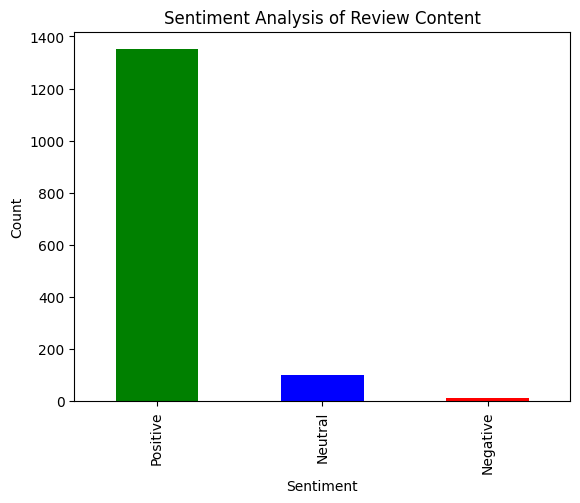

In [34]:
#Classify sentiment
def sentiment_analysis(text):
    analysis = TextBlob(text)
    #threshold for positive and negative sentiments
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

#Applying sentiment analysis to the review content
reviews = data['review_content']
reviews_sentiments = reviews.apply(sentiment_analysis)

# Counting the occurrences of each sentiment
sentiment_counts = reviews_sentiments.value_counts()

sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'], title='Sentiment Analysis of Review Content')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Berdasarkan hasil outputk, dapat dilihat produk yang dijual di amazon secara garis besar ditanggapi dengan review positif oleh para pembeli. Untuk lebih jelasnya dapat dilihat pada kode di bawah ini:

In [35]:
# Adding the sentiment labels back to the reviews
data['Sentiment'] = reviews_sentiments

# Finding examples of positive, neutral, and negative sentiments
positive_example = data[data['Sentiment'] == 'Positive'].iloc[0]
neutral_example = data[data['Sentiment'] == 'Neutral'].iloc[0]
negative_example = data[data['Sentiment'] == 'Negative'].iloc[0]

print("Example of sentiment review: ")
example_reviews = pd.DataFrame({
    "Sentiment": ["Positive", "Neutral", "Negative"],
    "Review": [positive_example['review_content'], neutral_example['review_content'], negative_example['review_content']],
    "Rating": [positive_example['rating'], neutral_example['rating'], negative_example['rating']]
})
example_reviews

Example of sentiment review: 


,Sentiment,Review,Rating
0,Positive,Looks durable Charging is fine tooNo complains...,4.2
1,Neutral,I am posting this after a few weeks of using t...,4.2
2,Negative,"Overall good.,TV picture ok smart betterSound ...",4.3


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


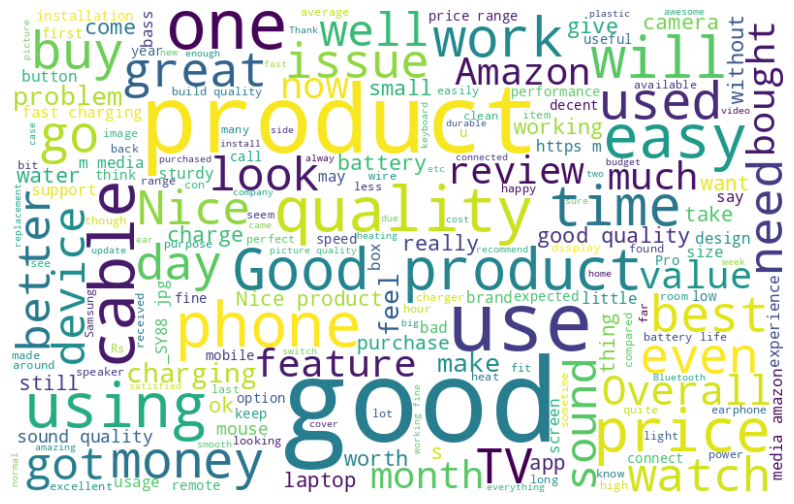

In [36]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in data['review_content']])
wordCloud(all_words)

### Keyword review dengan rating rendah

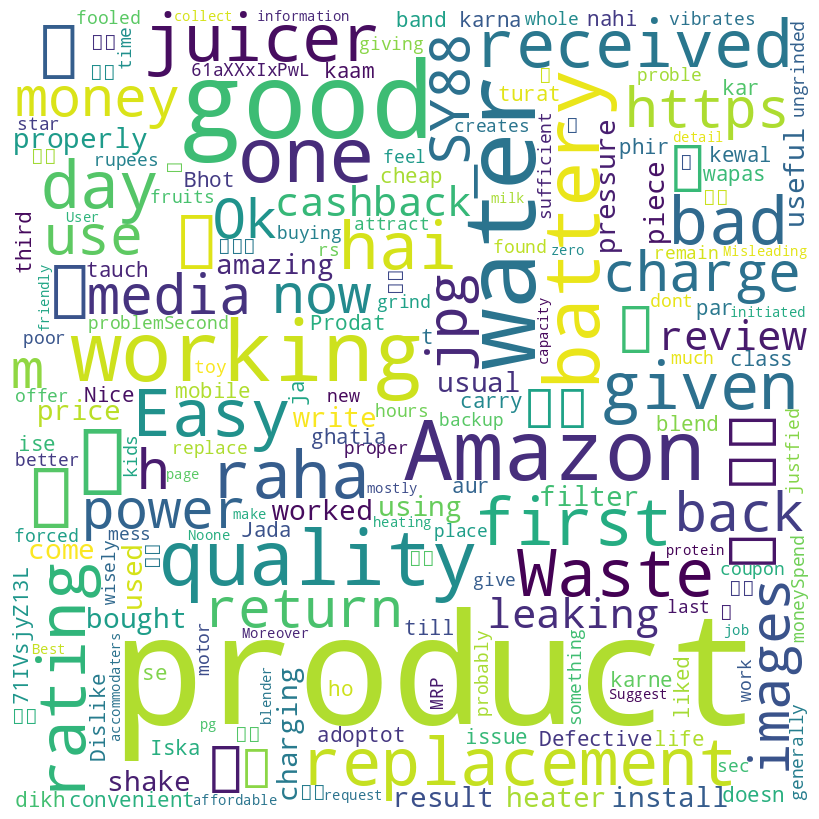

In [37]:
# Filter the dataframe to include only products with a rating lower than 3
low_rating_df = data[data['rating'] < 3.0]

# Create a string of all the reviews for these products
reviews_text = ' '.join(low_rating_df['review_content'].dropna().values)

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(reviews_text)

# Plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Data Preparation

## Seleksi Fitur

In [38]:
product_data = data.drop(['discounted_price', 'actual_price', 'discount_percentage', 'review_id', 'review_title',
                   'user_name', 'img_link', 'product_link'], axis=1)

product_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1464
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   product_id       1462 non-null   object  
 1   product_name     1462 non-null   object  
 2   category         1462 non-null   object  
 3   rating           1462 non-null   float64 
 4   rating_count     1462 non-null   float64 
 5   about_product    1462 non-null   object  
 6   user_id          1462 non-null   object  
 7   review_content   1462 non-null   object  
 8   rating_weighted  1462 non-null   float64 
 9   sub_category     1462 non-null   object  
 10  main_category    1462 non-null   object  
 11  cluster          1462 non-null   category
 12  Sentiment        1462 non-null   object  
dtypes: category(1), float64(3), object(9)
memory usage: 182.4+ KB


In [39]:
product_data['combined_text'] = product_data['product_name'] + ' ' + product_data['category'] + ' ' + product_data['about_product'] +' '+ product_data['review_content']
#Fill null with empty string to avoid issues
product_data['combined_text'] = product_data['combined_text'].fillna('')

## Label-Encoding the Sentiment


In [40]:
label_encoder = LabelEncoder()

# Fitting the encoder and transforming the 'Sentiment' column
product_data['Encoded_Sentiment'] = label_encoder.fit_transform(product_data['Sentiment'])

# Model Development and Evaluation

## Feature Engineering

TF-IDF (*Term Frequency-Inverse Document Frequency*) adalah metode yang bertujuan mengukur seberapa penting suatu kata terhadap kata-kata lain dalam dokumen. TF-IDF adalah skema representasi yang umum digunakan untuk sistem pengambilan informasi dan ekstraksi dokumen yang relevan dengan kueri tertentu.

In [41]:
#Instantiate TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, ngram_range=(1, 1))

vectorizer.fit(product_data['combined_text'])
vectorizer.get_feature_names_out()

array(['00', '000', '003', ..., '𝗳𝗼𝗿', '𝟱i', '𝟱you'], dtype=object)

In [42]:
#Fit and transform
tfidf_matrix = vectorizer.fit_transform(product_data['combined_text'])
tfidf_matrix.shape

(1462, 10264)

In [43]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.07650424, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

## Content Based Filtering using *Cosine Similarity Matrix*

Cosine similarity digunakan untuk menghitung derajat kesamaan (*similarity degree*) antar produk.


In [44]:
# Compute the cosine similarity matrix based on the tfidf_matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Print the shape of the cosine similarity matrix to verify
print(cosine_sim.shape)
print()

cosine_sim

(1462, 1462)



array([[1.        , 0.2086549 , 0.36301031, ..., 0.04792804, 0.07202106,
        0.00917733],
       [0.2086549 , 1.        , 0.17167792, ..., 0.01661349, 0.02681264,
        0.02333513],
       [0.36301031, 0.17167792, 1.        , ..., 0.04111945, 0.10637459,
        0.00743395],
       ...,
       [0.04792804, 0.01661349, 0.04111945, ..., 1.        , 0.12125324,
        0.04811391],
       [0.07202106, 0.02681264, 0.10637459, ..., 0.12125324, 1.        ,
        0.03085073],
       [0.00917733, 0.02333513, 0.00743395, ..., 0.04811391, 0.03085073,
        1.        ]])

In [45]:
def cbf_product_recommendations(id_product, similarity_data=cosine_sim, items=product_data, top_n = 10):
    """
    Rekomendasi product berdasarkan kemiripan dataframe

    Parameter:
    ---
    id_product : tipe data string (str)
                Id produk (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan product sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    index = items.index[items.product_id == id_product][0]

    sim_scores = list(enumerate(similarity_data[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    return [i[0] for i in sim_scores[1:top_n+1]]



In [46]:
sample_product_id = product_data['product_id'][0]
print(sample_product_id)

product_data.loc[product_data.product_id.eq(sample_product_id), ['product_id', 'product_name', 'category', 'sub_category']]

B07JW9H4J1


,product_id,product_name,category,sub_category
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,USBCables
369,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,USBCables
614,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,USBCables


In [47]:
# Mendapatkan data dengan Content-Based Filtering
product_data.iloc[cbf_product_recommendations(sample_product_id)][['product_name', 'category', 'sub_category']]

,product_name,category,sub_category
614,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,USBCables
369,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,USBCables
220,Wayona Nylon Braided Usb Syncing And Charging ...,Computers&Accessories|Accessories&Peripherals|...,USBCables
42,Wayona Nylon Braided 3A Lightning to USB A Syn...,Computers&Accessories|Accessories&Peripherals|...,USBCables
89,Wayona Nylon Braided (2 Pack) Lightning Fast U...,Computers&Accessories|Accessories&Peripherals|...,USBCables
80,Wayona Usb Nylon Braided Data Sync And Chargin...,Computers&Accessories|Accessories&Peripherals|...,USBCables
106,Wayona Nylon Braided 2M / 6Ft Fast Charge Usb ...,Computers&Accessories|Accessories&Peripherals|...,USBCables
166,Wayona Nylon Braided Lightning USB Data Sync &...,Computers&Accessories|Accessories&Peripherals|...,USBCables
208,MYVN LTG to USB for Fast Charging & Data Sync ...,Computers&Accessories|Accessories&Peripherals|...,USBCables
78,SWAPKART Fast Charging Cable and Data Sync USB...,Computers&Accessories|Accessories&Peripherals|...,USBCables


## Collaborative Filtering using RecommenderNet

In [48]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1464
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   product_id         1462 non-null   object  
 1   product_name       1462 non-null   object  
 2   category           1462 non-null   object  
 3   rating             1462 non-null   float64 
 4   rating_count       1462 non-null   float64 
 5   about_product      1462 non-null   object  
 6   user_id            1462 non-null   object  
 7   review_content     1462 non-null   object  
 8   rating_weighted    1462 non-null   float64 
 9   sub_category       1462 non-null   object  
 10  main_category      1462 non-null   object  
 11  cluster            1462 non-null   category
 12  Sentiment          1462 non-null   object  
 13  combined_text      1462 non-null   object  
 14  Encoded_Sentiment  1462 non-null   int64   
dtypes: category(1), float64(3), int64(1), object(10)
memory

In [49]:
df = product_data[['user_id', 'product_id', 'rating', 'rating_count', 'Encoded_Sentiment']]
df

,user_id,product_id,rating,rating_count,Encoded_Sentiment
0,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...",B07JW9H4J1,4.2,24269.0,2
1,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...",B098NS6PVG,4.0,43994.0,2
2,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...",B096MSW6CT,3.9,7928.0,2
3,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...",B08HDJ86NZ,4.2,94363.0,2
4,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...",B08CF3B7N1,4.2,16905.0,2
...,...,...,...,...,...
1460,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...",B08L7J3T31,4.0,1090.0,2
1461,"AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...",B01M6453MB,4.1,4118.0,2
1462,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ...",B009P2LIL4,3.6,468.0,2
1463,"AF2JQCLSCY3QJATWUNNHUSVUPNQQ,AFDMLUXC5LS5RXDJS...",B00J5DYCCA,4.0,8031.0,0


In [50]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_ids = df['user_id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke product_id: ', user_encoded_to_user)

list userID:  ['AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBBSNLYT3ONILA,AHCTC6ULH4XB6YHDY6PCH2R772LQ,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,AENGU523SXMOS7JPDTW52PNNVWGQ,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ', 'AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBXNGXZJT525AQ,AHONIZU3ICIEHQIGQ6R2VFRSBXOQ,AFPHD2CRPDZMWMBL7WXRSVYWS5JA,AEZ346GX3HJ4O4XNRPHCNHXQURMQ,AEPSWFPNECKO34PUC7I56ITGXR6Q,AHWVEHR5DYLVFTO2KF3IZATFQSWQ,AH4QT33M55677I7ISQOAKEQWACYQ', 'AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQLWQOWZ4N3OA,AHTPQRIMGUD4BYR5YIHBH3CCGEFQ,AEUVWXYP5LT7PZLLZENEO2NODPBQ,AHC7MPW55DOO6WNCOQVA2VHOD26A,AFDI6FRPFBTNBG7BAEB7JDJSMKDQ,AFQKCEEEKXCOHTDG4WUN3XPPHJQQ,AHKUUFNMBZIDLSSPA4FEHIO2EC7Q', 'AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5SGCUQBP7YSCA,AH725ST5NW2Y4JZPKUNTIJCUK2BA,AHV3TXIFCJPMS4D5JATCEUR266MQ,AGWIGDEMFIIUAOXYY2QATNBSUGHA,AFSTSLQUV4EVEXWKBOLEFHL2H5YQ,AGAKDNBHY2FKX7I4ACRGILU7QL7A,AFNWJUWJRHCC6HN52KMG5AKZY37Q', 'AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDS

In [51]:
# Mengubah product_id menjadi list tanpa nilai yang sama
product_ids = df['product_id'].unique().tolist()
print('list product_id: ', user_ids)

# Melakukan proses encoding product_id
product_to_product_encoded = {x: i for i, x in enumerate(product_ids)}
print('encoded product_id : ', product_to_product_encoded)

# Melakukan proses encoding angka ke product_id
product_encoded_to_product = {i: x for i, x in enumerate(product_ids)}
print('encoded angka ke product_id: ', product_encoded_to_product)

list product_id:  ['AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBBSNLYT3ONILA,AHCTC6ULH4XB6YHDY6PCH2R772LQ,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,AENGU523SXMOS7JPDTW52PNNVWGQ,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ', 'AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBXNGXZJT525AQ,AHONIZU3ICIEHQIGQ6R2VFRSBXOQ,AFPHD2CRPDZMWMBL7WXRSVYWS5JA,AEZ346GX3HJ4O4XNRPHCNHXQURMQ,AEPSWFPNECKO34PUC7I56ITGXR6Q,AHWVEHR5DYLVFTO2KF3IZATFQSWQ,AH4QT33M55677I7ISQOAKEQWACYQ', 'AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQLWQOWZ4N3OA,AHTPQRIMGUD4BYR5YIHBH3CCGEFQ,AEUVWXYP5LT7PZLLZENEO2NODPBQ,AHC7MPW55DOO6WNCOQVA2VHOD26A,AFDI6FRPFBTNBG7BAEB7JDJSMKDQ,AFQKCEEEKXCOHTDG4WUN3XPPHJQQ,AHKUUFNMBZIDLSSPA4FEHIO2EC7Q', 'AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5SGCUQBP7YSCA,AH725ST5NW2Y4JZPKUNTIJCUK2BA,AHV3TXIFCJPMS4D5JATCEUR266MQ,AGWIGDEMFIIUAOXYY2QATNBSUGHA,AFSTSLQUV4EVEXWKBOLEFHL2H5YQ,AGAKDNBHY2FKX7I4ACRGILU7QL7A,AFNWJUWJRHCC6HN52KMG5AKZY37Q', 'AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAF

In [52]:
# Mapping userID ke dataframe user
df['user'] = df['user_id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
df['product'] = df['product_id'].map(product_to_product_encoded)

In [53]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah product
num_product = len(product_encoded_to_product)
print(num_product)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of product: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_product, min_rating, max_rating
))

1191
1348
Number of User: 1191, Number of product: 1348, Min Rating: 2.0, Max Rating: 5.0


Training dan validasi

In [54]:
# Mengacak dataset
df = df.sample(frac=1,random_state=42)
df

,user_id,product_id,rating,rating_count,Encoded_Sentiment,user,product
894,"AHDFR3PDKEBV72HXRL3RJJLS3YYA,AHYUZ2BLKNN6UJLFY...",B07P681N66,4.4,24780.0,2,43,50
1108,"AE5LEWHQDGISBMSHQ3QRHVAO5ROQ,AHFZEHT2WQTE2ZR4S...",B013B2WGT6,4.3,15276.0,2,835,992
415,"AHCZZTKJ5WN7WJSQU3HWL2LK6XQA,AE6OITGK4Q3JK2PM6...",B085W8CFLH,3.5,83996.0,1,302,407
524,"AFAKLGJPBTX3EWCXJWB6TF4LJOXQ,AHR5LL4YACXI5EFTG...",B09VZBGL1N,4.1,2451.0,2,356,500
1038,"AGEWFIJDNQ73TIDHQIEMY6PTF7SQ,AGWAYDRCPJOSWY4HN...",B08KDBLMQP,4.0,6530.0,1,765,922
...,...,...,...,...,...,...,...
1132,"AGVCTA243VHAYH4RQKB4TVYSPC7Q,AH36BC5JQPIM7MZOM...",B091KNVNS9,4.1,1240.0,2,859,1016
1297,"AHX7I43IUBTBR5SMBWXO2VWLFLDA,AGUV5JDS7DN6OSZ2C...",B072NCN9M4,4.2,3065.0,2,1023,1180
862,"AHI7MFQMUC5N6DRDGTYZPAKPWF2A,AF4YTGSRB6V6GKOAS...",B09NC2TY11,4.1,5852.0,2,622,775
1462,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ...",B009P2LIL4,3.6,468.0,2,1188,1345


In [55]:
# Membuat variabel x untuk mencocokkan data user dan product menjadi satu value
x = df[['user', 'product']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  43   50]
 [ 835  992]
 [ 302  407]
 ...
 [ 622  775]
 [1188 1345]
 [ 855 1012]] [0.8        0.76666667 0.5        ... 0.7        0.53333333 0.7       ]


In [56]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_product, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_product = num_product
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.product_embedding = layers.Embedding( # layer embeddings product
        num_product,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.product_bias = layers.Embedding(num_product, 1) # layer embedding product bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    product_vector = self.product_embedding(inputs[:, 1]) # memanggil layer embedding 3
    product_bias = self.product_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_product = tf.tensordot(user_vector, product_vector, 2)

    x = dot_user_product + user_bias + product_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [57]:
model = RecommenderNet(num_users, num_product, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [58]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
147/147 [==============================] - 3s 5ms/step - loss: 0.6912 - root_mean_squared_error: 0.2193 - val_loss: 0.6894 - val_root_mean_squared_error: 0.2141
Epoch 2/100
147/147 [==============================] - 1s 3ms/step - loss: 0.6548 - root_mean_squared_error: 0.1732 - val_loss: 0.6827 - val_root_mean_squared_error: 0.2060
Epoch 3/100
147/147 [==============================] - 1s 4ms/step - loss: 0.6246 - root_mean_squared_error: 0.1240 - val_loss: 0.6777 - val_root_mean_squared_error: 0.1999
Epoch 4/100
147/147 [==============================] - 0s 3ms/step - loss: 0.6114 - root_mean_squared_error: 0.0966 - val_loss: 0.6745 - val_root_mean_squared_error: 0.1958
Epoch 5/100
147/147 [==============================] - 1s 4ms/step - loss: 0.6091 - root_mean_squared_error: 0.0912 - val_loss: 0.6749 - val_root_mean_squared_error: 0.1964
Epoch 6/100
147/147 [==============================] - 1s 4ms/step - loss: 0.6073 - root_mean_squared_error: 0.0867 - val_loss: 0.6749 

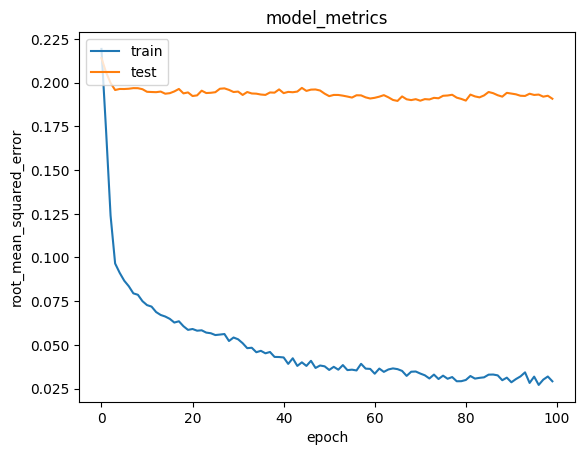

In [59]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
df = product_data

user_id = df.user_id.sample(1).iloc[0]
product_bought_by_user = df[df.user_id == user_id]

product_not_bought = df[~df['product_id'].isin(product_bought_by_user.product_id.values)]['product_id']
product_not_bought = list(
    set(product_not_bought)
    .intersection(set(product_to_product_encoded.keys()))
)

product_not_bought = [[product_to_product_encoded.get(x)] for x in product_not_bought]
user_encoder = user_to_user_encoded.get(user_id)
user_product_array = np.hstack(
    ([[user_encoder]] * len(product_not_bought ), product_not_bought)
)
user_product_array

array([[  20, 1063],
       [  20,  614],
       [  20,  498],
       ...,
       [  20,  728],
       [  20,  938],
       [  20,  511]])

In [61]:
ratings = model.predict(user_product_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_product_ids = [
    product_encoded_to_product.get(product_not_bought[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Product with high ratings from user')
print('----' * 8)

top_product_user = (
    product_bought_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .product_id.values
)

product_df_rows = product_data[product_data['product_id'].isin(top_product_user)]
for row in product_df_rows.itertuples():
    print(row.product_name, ':', row.category, 'with rating', row.rating)

print('----' * 8)
print('Top 10 product recommendation')
print('----' * 8)

recommended_product = product_data[product_data['product_id'].isin(recommended_product_ids)]
recommended_product[['product_name', 'category', 'sub_category', 'rating']]
# for row in recommended_product.itertuples():
    # print(row.product_id, ':', row.category, 'with rating', row.rating)

42/42 [==============================] - 0s 1ms/step
Showing recommendations for users: AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,AE55KTFVNXYFD5FPYWP2OUPEYNPQ,AEBWA5I4QFCA3P3OBEPMELBGN4GQ,AHMGAC6QM62UXNEOCZIHLHSXPP2Q,AFHROSCGIXUPV3FYQ7H5QOD46Q7Q,AEAMIR3CMSA32IDEINSJKHRNANTA,AF355FTXYAKFH5NYPRTE7SL3WO3Q,AG5DWPD54QGSLWJ6QUFERLPNAX4Q
Product with high ratings from user
--------------------------------
Flix Micro Usb Cable For Smartphone (Black) : Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables with rating 4.0
FLiX (Beetel USB to Micro USB PVC Data Sync & 2A Fast Charging Cable, Made in India, 480Mbps Data Sync, Solid Cable, 1 Meter Long USB Cable for Micro USB Devices (White)(XCD-M11) : Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables with rating 4.0
Flix (Beetel) Usb To Type C Pvc Data Sync And 2A 480Mbps Data Sync, Tough Fast Charging Long Cable For Usb Type C Devices, Charging Adapter (White, 1 Meter) - Xcd-C12 : Computers&Accessori

,product_name,category,sub_category,rating
174,Syncwire LTG to USB Cable for Fast Charging Co...,Computers&Accessories|Accessories&Peripherals|...,USBCables,5.0
249,Sony Bravia 164 cm (65 inches) 4K Ultra HD Sma...,"Electronics|HomeTheater,TV&Video|Televisions|S...",SmartTelevisions,4.7
459,Spigen EZ Fit Tempered Glass Screen Protector ...,Electronics|Mobiles&Accessories|MobileAccessor...,ScreenProtectors,4.7
775,Amazon Basics Wireless Mouse | 2.4 GHz Connect...,Computers&Accessories|Accessories&Peripherals|...,Mice,5.0
820,Redgear MP35 Speed-Type Gaming Mousepad (Black...,Computers&Accessories|Accessories&Peripherals|...,Gamepads,4.6
886,"Logitech M331 Silent Plus Wireless Mouse, 2.4G...",Computers&Accessories|Accessories&Peripherals|...,Mice,4.6
1201,"Oratech Coffee Frother electric, milk frother ...",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,HandBlenders,4.8
1223,"FIGMENT Handheld Milk Frother Rechargeable, 3-...",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,HandBlenders,4.7
1299,"Instant Pot Air Fryer, Vortex 2QT, Touch Contr...",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,AirFryers,4.8
1388,Campfire Spring Chef Prolix Instant Portable W...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",InstantWaterHeaters,4.7


## Hybrid Recommendation System

Fungsi di bawah ini, kita akan membuat **sistem rekomendasi hybrid** dengan menggabungkan ***content-based filtering*** dan ***collaborative filtering***. Pertama, Identifikasi produk serupa untuk setiap id_produk dengan menggunakan *content-based filtering* dengan menggunakan TF-IDF vectorization dari fitur produk untuk menghitung skor *cosine similarity* dengan produk lain. Bagian sistem ini mengenali produk dengan fitur yang serupa. Lalu gunakan *collaborative filtering* dengan menguji rating produk target dan mencari produk lain dengan rating serupa, mengasumsikan produk dengan rating serupa mungkin cocok dengan preferensi user.

In [66]:
def hybrid_recommendation(product_id, content_sim_matrix, products, top_n=10):

    #Content-based filtering
    content_recommendations_idx = cbf_product_recommendations(product_id, similarity_data=content_sim_matrix, items=products, top_n = top_n)

    #Combine content and collaborative recommendations
    #Get indices for collaborative recommendations
    collaborative_recommendations_idx = recommended_product_ids
    # print(collaborative_recommendations_idx)
    #Map indices to product IDs
    collaborative_recommendations_idx = [products.index[products['product_id'] == pid].tolist()[0] for pid in collaborative_recommendations_idx]

    #Combine indices from both methods and remove duplicates
    combined_indices = list(set(content_recommendations_idx + collaborative_recommendations_idx))

    #Get recommended products details
    recommended_products = products.iloc[combined_indices].copy()
    recommended_products = recommended_products[['product_id', 'product_name','category', 'sub_category', 'rating']]

    return recommended_products

In [67]:
sample_product_id = product_data['product_id'][0]
sample_product_name = product_data['product_name'][0]
recommended_products = hybrid_recommendation(sample_product_id, cosine_sim, product_data)
print("Recommendation for user who purchased product \"" + sample_product_name + "\"")
recommended_products.head(10)

Recommendation for user who purchased product "Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)"


,product_id,product_name,category,sub_category,rating
777,B016XVRKZM,"APC Back-UPS BX600C-IN 600VA / 360W, 230V, UPS...",Computers&Accessories|Accessories&Peripherals|...,UninterruptedPowerSupplies,3.9
1302,B009UORDX4,Philips Hi113 1000-Watt Plastic Body Ptfe Coat...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",DryIrons,4.3
166,B07JPJJZ2H,Wayona Nylon Braided Lightning USB Data Sync &...,Computers&Accessories|Accessories&Peripherals|...,USBCables,4.2
42,B07JW1Y6XV,Wayona Nylon Braided 3A Lightning to USB A Syn...,Computers&Accessories|Accessories&Peripherals|...,USBCables,4.2
174,B0BP7XLX48,Syncwire LTG to USB Cable for Fast Charging Co...,Computers&Accessories|Accessories&Peripherals|...,USBCables,5.0
1203,B07NKNBTT3,Pick Ur Needs® Lint Remover for Clothes High R...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",LintShavers,4.1
822,B00MUTWLW4,Logitech K480 Wireless Multi-Device Keyboard f...,Computers&Accessories|Accessories&Peripherals|...,Keyboards,4.4
1225,B09SZ5TWHW,Swiss Military VC03 Wireless Car Vacuum Cleane...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",HandheldVacuums,3.9
461,B0971DWFDT,Portronics CarPower Mini Car Charger with Dual...,Electronics|Mobiles&Accessories|MobileAccessor...,AutomobileChargers,4.2
78,B0B2DJDCPX,SWAPKART Fast Charging Cable and Data Sync USB...,Computers&Accessories|Accessories&Peripherals|...,USBCables,3.9
